In [ ]:

# ================================================================
# CELL 1: Kiểm tra GPU
# ================================================================

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("⚠️ WARNING: Không có GPU!")
    print("👉 Vào Runtime > Change runtime type > chọn T4 GPU")


PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 14.74 GB


In [ ]:
# ================================================================
# CELL 2: Cài đặt Ultralytics
# ================================================================

!pip install -q ultralytics

from ultralytics import YOLO
import os

print("✅ Ultralytics đã cài đặt!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Ultralytics đã cài đặt!


In [ ]:
# ================================================================
# CELL 3: Mount Google Drive
# ================================================================

from google.colab import drive
drive.mount('/content/drive')

print("✅ Đã kết nối Google Drive!")

Mounted at /content/drive
✅ Đã kết nối Google Drive!


In [ ]:
# ================================================================
# CELL 4: Giải nén dataset
# ================================================================

import zipfile
import shutil
import os

# Đường dẫn đến file zip trong Drive
zip_path = "/content/drive/MyDrive/Colab Notebooks/Bike Helmet Detection.v1-bboxblur-resized.yolov8.zip"

# Giải nén vào /content/dataset
dataset_path = "/content/dataset"

print("📦 Đang giải nén dataset...")
print(f"Từ: {zip_path}")
print(f"Đến: {dataset_path}")

# Xóa thư mục cũ nếu có
if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)

os.makedirs(dataset_path)

# Giải nén
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

print("✅ Giải nén hoàn tất!")

# Kiểm tra cấu trúc
print("\n📁 Cấu trúc dataset:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    if level < 2:  # Chỉ hiện 2 cấp
        sub_indent = ' ' * 2 * (level + 1)
        for file in files[:3]:
            print(f'{sub_indent}{file}')
        if len(files) > 3:
            print(f'{sub_indent}... và {len(files)-3} files khác')


📦 Đang giải nén dataset...
Từ: /content/drive/MyDrive/Colab Notebooks/Bike Helmet Detection.v1-bboxblur-resized.yolov8.zip
Đến: /content/dataset
✅ Giải nén hoàn tất!

📁 Cấu trúc dataset:
dataset/
  README.dataset.txt
  data.yaml
  README.roboflow.txt
  valid/
    labels/
    images/
  train/
    labels/
    images/
  test/
    labels/
    images/


📊 Số lượng đối tượng theo nhãn:
 - Nhãn 0: 2262 đối tượng
 - Nhãn 1: 1162 đối tượng


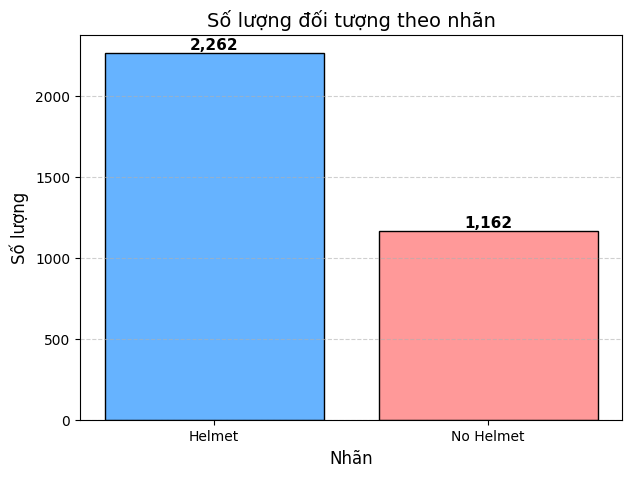

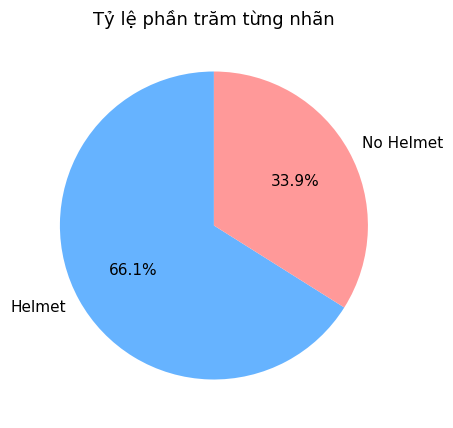

In [ ]:
# ================================================================
# CELL 5: Thống kê & trực quan hóa số lượng đối tượng theo nhãn
# ================================================================

import os
import matplotlib.pyplot as plt
from collections import Counter

# Các thư mục nhãn train + valid
label_dirs = [
    os.path.join(dataset_path, "train", "labels"),
    os.path.join(dataset_path, "valid", "labels")
]

label_counts = Counter()

# Đọc toàn bộ file nhãn
for labels_dir in label_dirs:
    if not os.path.exists(labels_dir):
        continue
    for root, dirs, files in os.walk(labels_dir):
        for file in files:
            if file.endswith(".txt"):
                with open(os.path.join(root, file), "r") as f:
                    for line in f:
                        cls_id = line.strip().split()[0]
                        label_counts[int(cls_id)] += 1

# In kết quả
print("📊 Số lượng đối tượng theo nhãn:")
for k, v in label_counts.items():
    print(f" - Nhãn {k}: {v} đối tượng")

# Đặt tên nhãn (tuỳ theo dataset của bạn)
class_names = ["Helmet", "No Helmet"]

# Dữ liệu vẽ
labels = class_names[:len(label_counts)]
counts = list(label_counts.values())

# --- Biểu đồ cột ---
plt.figure(figsize=(7,5))
bars = plt.bar(labels, counts, color=['#66b3ff', '#ff9999'], edgecolor='black')
plt.title("Số lượng đối tượng theo nhãn", fontsize=14)
plt.xlabel("Nhãn", fontsize=12)
plt.ylabel("Số lượng", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Hiện số chi tiết trên đầu cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, f"{yval:,}",
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.show()

# --- Biểu đồ tròn ---
plt.figure(figsize=(5,5))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90,
        colors=['#66b3ff', '#ff9999'], textprops={'fontsize': 11})
plt.title("Tỷ lệ phần trăm từng nhãn", fontsize=13)
plt.show()



In [ ]:
# ================================================================
# CELL 6: Augment nhãn "No Helmet" (~2100 đối tượng)
# ================================================================

import random
from pathlib import Path
import cv2
import albumentations as A
import shutil

# --- Thư mục train ---
train_images_dir = Path(dataset_path) / "train" / "images"
train_labels_dir = Path(dataset_path) / "train" / "labels"

# --- Thư mục augmented (ngoài train) ---
augmented_dir = Path(dataset_path) / "augmented"
augmented_images_dir = augmented_dir / "images"
augmented_labels_dir = augmented_dir / "labels"

# --- Xóa dữ liệu cũ nếu có ---
if augmented_dir.exists():
    shutil.rmtree(augmented_dir)
augmented_images_dir.mkdir(parents=True, exist_ok=True)
augmented_labels_dir.mkdir(parents=True, exist_ok=True)

# --- Pipeline augmentation ---
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.7),
    A.RandomBrightnessContrast(p=0.5)
])

# --- Lấy danh sách file nhãn "No Helmet" gốc ---
no_helmet_files = []
no_helmet_counts_per_file = []  # lưu số đối tượng No Helmet trong mỗi file
for label_file in train_labels_dir.glob("*.txt"):
    with open(label_file, "r") as f:
        lines = f.readlines()
        count_no = sum(1 for line in lines if int(line.split()[0]) == 1)
        if count_no > 0:
            no_helmet_files.append(label_file.stem)
            no_helmet_counts_per_file.append(count_no)

# --- Tính số đối tượng No Helmet hiện tại ---
current_no_helmet = sum(no_helmet_counts_per_file)
target_no_helmet = 2100
remaining = target_no_helmet - current_no_helmet
print(f"Hiện tại có {current_no_helmet} đối tượng 'No Helmet'")
print(f"Cần augment thêm khoảng {remaining} đối tượng")

if remaining <= 0:
    print("✅ Đã đủ ~2100 đối tượng 'No Helmet'. Không cần augment thêm.")
else:
    idx = 0
    while remaining > 0:
        stem = no_helmet_files[idx % len(no_helmet_files)]
        count_in_file = no_helmet_counts_per_file[idx % len(no_helmet_counts_per_file)]
        idx += 1

        # Nếu thêm toàn bộ bbox sẽ vượt target, chỉ thêm 1 bbox duy nhất
        if count_in_file > remaining:
            count_in_file = remaining

        # Load ảnh gốc
        img_path = train_images_dir / f"{stem}.jpg"
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"⚠️ Không tìm thấy ảnh: {img_path}")
            continue

        # Augmentation
        aug_img = transform(image=img)['image']
        new_name = f"{stem}_aug_{random.randint(1000,9999)}.jpg"
        cv2.imwrite(str(augmented_images_dir / new_name), aug_img)

        # Tạo file nhãn chỉ chứa đủ số bbox cần thiết
        src_label_path = train_labels_dir / f"{stem}.txt"
        dst_label_path = augmented_labels_dir / f"{Path(new_name).stem}.txt"
        with open(src_label_path, "r") as f_src, open(dst_label_path, "w") as f_dst:
            written = 0
            for line in f_src:
                cls_id = int(line.strip().split()[0])
                if cls_id == 1 and written < count_in_file:
                    f_dst.write(line)
                    written += 1

        remaining -= count_in_file

    print(f"✅ Augment xong, tổng số đối tượng 'No Helmet' ~ {target_no_helmet}")


Hiện tại có 1047 đối tượng 'No Helmet'
Cần augment thêm khoảng 1053 đối tượng
✅ Augment xong, tổng số đối tượng 'No Helmet' ~ 2100


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


📊 Số lượng đối tượng sau augment:
 - Nhãn 0 (Helmet): 2078 đối tượng
 - Nhãn 1 (No Helmet): 2100 đối tượng


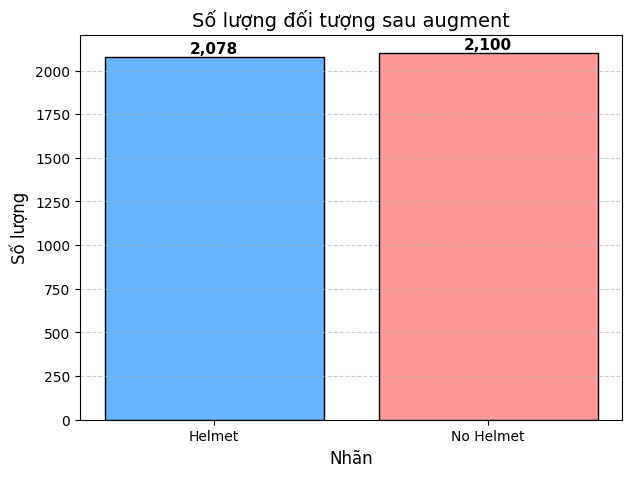

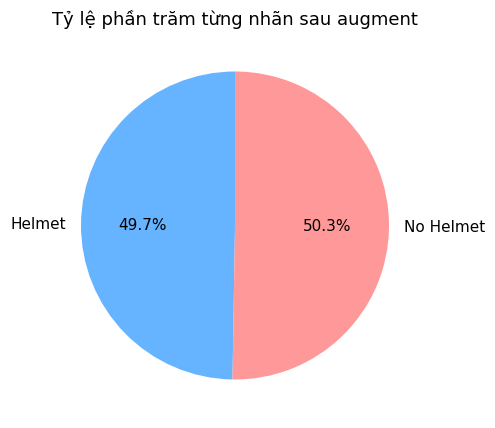

In [ ]:
# ================================================================
# CELL 7: Thống kê & trực quan hóa số lượng đối tượng (an toàn)
# ================================================================

import matplotlib.pyplot as plt
from collections import Counter

def visualize_label_counts(label_dirs, class_names=None, title_suffix=""):
    label_counts = Counter()

    # Đếm nhãn
    for labels_dir in label_dirs:
        labels_dir = Path(labels_dir)
        if not labels_dir.exists():
            continue
        for label_file in labels_dir.glob("*.txt"):
            with open(label_file, "r") as f:
                for line in f:
                    cls_id = int(line.strip().split()[0])
                    label_counts[cls_id] += 1

    # In kết quả
    print(f"📊 Số lượng đối tượng{title_suffix}:")
    for k, v in sorted(label_counts.items()):
        name = class_names[k] if class_names and k < len(class_names) else str(k)
        print(f" - Nhãn {k} ({name}): {v} đối tượng")

    # Biểu đồ
    labels = [class_names[i] for i in range(len(label_counts))] if class_names else [str(k) for k in label_counts]
    counts = [label_counts[i] for i in range(len(labels))]

    # Biểu đồ cột
    plt.figure(figsize=(7,5))
    bars = plt.bar(labels, counts, color=['#66b3ff', '#ff9999'], edgecolor='black')
    plt.title(f"Số lượng đối tượng{title_suffix}", fontsize=14)
    plt.xlabel("Nhãn", fontsize=12)
    plt.ylabel("Số lượng", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 5, f"{yval:,}",
                 ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.show()

    # Biểu đồ tròn
    plt.figure(figsize=(5,5))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90,
            colors=['#66b3ff', '#ff9999'], textprops={'fontsize': 11})
    plt.title(f"Tỷ lệ phần trăm từng nhãn{title_suffix}", fontsize=13)
    plt.show()


# =========================
# Sử dụng hàm thống kê sau augment
# =========================
train_label_dir = Path(dataset_path) / "train" / "labels"
aug_label_dir = Path(dataset_path) / "augmented" / "labels"

visualize_label_counts(
    label_dirs=[train_label_dir, aug_label_dir],
    class_names=["Helmet", "No Helmet"],
    title_suffix=" sau augment"
)




In [ ]:
from pathlib import Path
import shutil

# --- Đường dẫn ---
dataset_path = Path("/content/dataset")
train_images = dataset_path / "train" / "images"
train_labels = dataset_path / "train" / "labels"
aug_images = dataset_path / "augmented" / "images"
aug_labels = dataset_path / "augmented" / "labels"

# --- Gộp dữ liệu augment vào train ---
merged_count = 0
for img_path in aug_images.glob("*.jpg"):
    stem = img_path.stem
    lbl_path = aug_labels / f"{stem}.txt"
    if lbl_path.exists():
        shutil.copy(img_path, train_images / img_path.name)
        shutil.copy(lbl_path, train_labels / lbl_path.name)
        merged_count += 1

print(f"✅ Đã gộp {merged_count} ảnh augment vào thư mục train.")
print(f"Tổng số ảnh train sau khi gộp: {len(list(train_images.glob('*.jpg')))}")


✅ Đã gộp 458 ảnh augment vào thư mục train.
Tổng số ảnh train sau khi gộp: 1640


📊 Số lượng đối tượng theo nhãn:
 - Nhãn 0: 2262 đối tượng
 - Nhãn 1: 2215 đối tượng


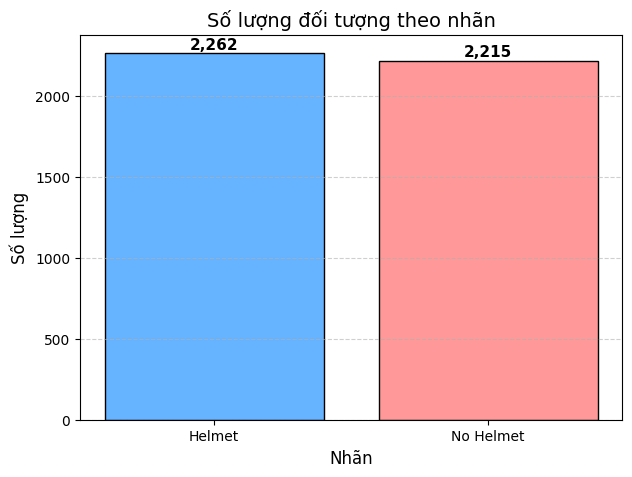

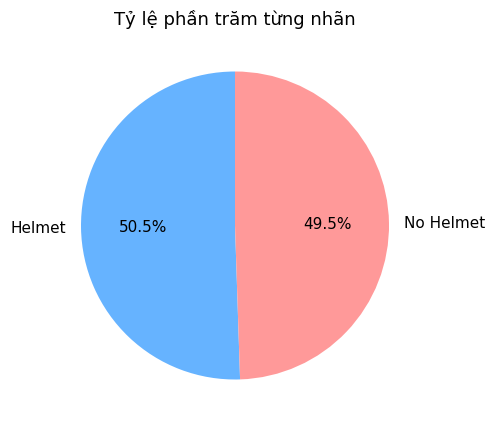

In [ ]:
# ================================================================
# CELL 5: Thống kê & trực quan hóa số lượng đối tượng theo nhãn
# ================================================================

import os
import matplotlib.pyplot as plt
from collections import Counter

# Các thư mục nhãn train + valid
label_dirs = [
    os.path.join(dataset_path, "train", "labels"),
    os.path.join(dataset_path, "valid", "labels")
]

label_counts = Counter()

# Đọc toàn bộ file nhãn
for labels_dir in label_dirs:
    if not os.path.exists(labels_dir):
        continue
    for root, dirs, files in os.walk(labels_dir):
        for file in files:
            if file.endswith(".txt"):
                with open(os.path.join(root, file), "r") as f:
                    for line in f:
                        cls_id = line.strip().split()[0]
                        label_counts[int(cls_id)] += 1

# In kết quả
print("📊 Số lượng đối tượng theo nhãn:")
for k, v in label_counts.items():
    print(f" - Nhãn {k}: {v} đối tượng")

# Đặt tên nhãn (tuỳ theo dataset của bạn)
class_names = ["Helmet", "No Helmet"]

# Dữ liệu vẽ
labels = class_names[:len(label_counts)]
counts = list(label_counts.values())

# --- Biểu đồ cột ---
plt.figure(figsize=(7,5))
bars = plt.bar(labels, counts, color=['#66b3ff', '#ff9999'], edgecolor='black')
plt.title("Số lượng đối tượng theo nhãn", fontsize=14)
plt.xlabel("Nhãn", fontsize=12)
plt.ylabel("Số lượng", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Hiện số chi tiết trên đầu cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, f"{yval:,}",
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.show()

# --- Biểu đồ tròn ---
plt.figure(figsize=(5,5))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90,
        colors=['#66b3ff', '#ff9999'], textprops={'fontsize': 11})
plt.title("Tỷ lệ phần trăm từng nhãn", fontsize=13)
plt.show()

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11s.pt")  # ✅ đúng tên file mô hình YOLOv11


In [ ]:
# ================================================================
# 🧠 CELL 6: TRAIN YOLOv11 MODEL - PHÁT HIỆN MŨ BẢO HIỂM (CÂN BẰNG NHẤT)
# ================================================================

import os
from ultralytics import YOLO

# ================================================================
# 1️⃣ Đường dẫn YAML (file cấu hình dataset)
# ================================================================
dataset_path = "/content/dataset"  # 👉 Thay đường dẫn này nếu khác
yaml_path = os.path.join(dataset_path, "data.yaml")

# ================================================================
# 2️⃣ Khởi tạo mô hình YOLOv11
# ================================================================
model = YOLO("yolo11s.pt")  # ✅ pretrained trên COCO

# ================================================================
# 3️⃣ Huấn luyện mô hình
# ================================================================
results = model.train(
    # --- Dataset ---
    data=yaml_path,
    epochs=30,
    patience=10,

    # --- Image & Batch ---
    imgsz=640,
    batch=16,

    # --- Device & Workers ---
    device=0,          # dùng GPU nếu có
    workers=2,

    # --- Optimizer & Learning rate ---
    optimizer="AdamW",   # YOLOv11 default là AdamW, có thể đổi nếu muốn ổn định hơn
    lr0=0.001,
    lrf=0.01,

    # --- Data Augmentation ---
    augment=True,
    scale=0.4,
    fliplr=0.5,
    flipud=0.05,

    # --- Kỹ thuật hỗ trợ cân bằng class ---
    mosaic=0.8,
    auto_augment="randaugment",

    # --- Validation & Lưu kết quả ---
    val=True,
    plots=True,
    save=True,
    save_period=10,

    # --- Thư mục output ---
    project="/content/runs/detect",
    name="helmet_yolo11s_30ep_balanced",
    exist_ok=True,

    # --- Logging ---
    verbose=True,
)

# ================================================================
# 4️⃣ Thông báo hoàn tất
# ================================================================
print("\n" + "=" * 60)
print("✅ TRAINING HOÀN TẤT - KẾT QUẢ LƯU TRONG /content/runs/detect/helmet_yolo11s_30ep_balanced")
print("=" * 60)


Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.05, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=0.8, multi_scale=False, name=helmet_yolo11s_30ep_balanced, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=10, perspective=0.0, pl